In [1]:
# Make all the imports
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import seaborn as sns
from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pickle

In [2]:
# utility functions

def process_jpg_image(img):
  img = tf.convert_to_tensor(img[:,:,:3])
  img = np.expand_dims(img, axis = 0)
  img = tf.image.resize(img,[224,224])
  img = (img/255.0)
  return img

def show_confusion_matrix(cm, labels):
    '''
    plots heatmap of confusion matrix'''
    plt.figure(figsize=(15, 10))
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

In [3]:
# Load all the images. training folder is split 20% as validation set and testing folder is loaded as test dataset.

train_dir = r"D:\CDriveDesktopData\Sem 6\Mini-Proj-ML\Mini Project\dataset"
preprocess_input = tf.keras.applications.vgg16.preprocess_input
TARGET_SIZE = 224
BATCH_SIZE = 64


train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255)


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    subset="training",
                                                    shuffle = True,
                                                    target_size=(TARGET_SIZE,TARGET_SIZE))

validation_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    subset="validation",
                                                    shuffle = False,
                                                    target_size=(TARGET_SIZE,TARGET_SIZE))
#test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
#test_generator = test_datagen.flow_from_directory(test_dir,
#                                                  batch_size=BATCH_SIZE,
#                                                  class_mode='categorical',
#                                                  shuffle=False,
#                                                  target_size=(TARGET_SIZE,TARGET_SIZE))


Found 500 images belonging to 2 classes.
Found 125 images belonging to 2 classes.


In [4]:
# Print all the classes

train_generator.class_indices

{'fake': 0, 'real': 1}

In [5]:
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64, 2)


In [6]:
# Using a VGG model for training

from tensorflow.keras.applications.vgg16 import VGG16


base_model = VGG16(weights='imagenet', input_shape=(TARGET_SIZE, TARGET_SIZE, 3), include_top=False)
base_model.trainable = False

# Adding a model on top

inputs = tf.keras.Input(shape=(TARGET_SIZE, TARGET_SIZE, 3))

x = base_model.output
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

vgg = tf.keras.Model(inputs=base_model.input, outputs=output)


In [7]:
vgg.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
opt = tf.keras.optimizers.Adam()
cce = tf.keras.losses.BinaryCrossentropy()
vgg.compile(optimizer=opt, loss=cce, metrics= ['acc'])

In [9]:
checkpoint_filepath = '/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [27]:
EPOCHS = 10
NUM_STEPS = train_generator.samples/BATCH_SIZE
VAL_NUM_STEPS = validation_generator.samples/BATCH_SIZE
model = vgg.fit(train_generator, epochs = EPOCHS, steps_per_epoch = NUM_STEPS, validation_steps = VAL_NUM_STEPS, validation_data = validation_generator, callbacks=[reduce_lr])

Epoch 1/10
7/7 [==============================] - 106s 14s/step - loss: 0.5432 - acc: 0.8040 - val_loss: 0.4898 - val_acc: 0.8560 - lr: 0.0010
Epoch 2/10
7/7 [==============================] - 109s 14s/step - loss: 0.5265 - acc: 0.8200 - val_loss: 0.4548 - val_acc: 0.8960 - lr: 0.0010
Epoch 3/10
7/7 [==============================] - 109s 14s/step - loss: 0.4881 - acc: 0.8340 - val_loss: 0.4100 - val_acc: 0.9360 - lr: 0.0010
Epoch 4/10
7/7 [==============================] - 109s 14s/step - loss: 0.4495 - acc: 0.8620 - val_loss: 0.3606 - val_acc: 0.9360 - lr: 0.0010
Epoch 5/10
7/7 [==============================] - 109s 14s/step - loss: 0.4254 - acc: 0.8620 - val_loss: 0.3109 - val_acc: 0.9440 - lr: 0.0010
Epoch 6/10
7/7 [==============================] - 109s 14s/step - loss: 0.3840 - acc: 0.8660 - val_loss: 0.2872 - val_acc: 0.9280 - lr: 0.0010
Epoch 7/10
7/7 [==============================] - 109s 14s/step - loss: 0.3748 - acc: 0.8620 - val_loss: 0.2568 - val_acc: 0.9360 - lr: 0.0010

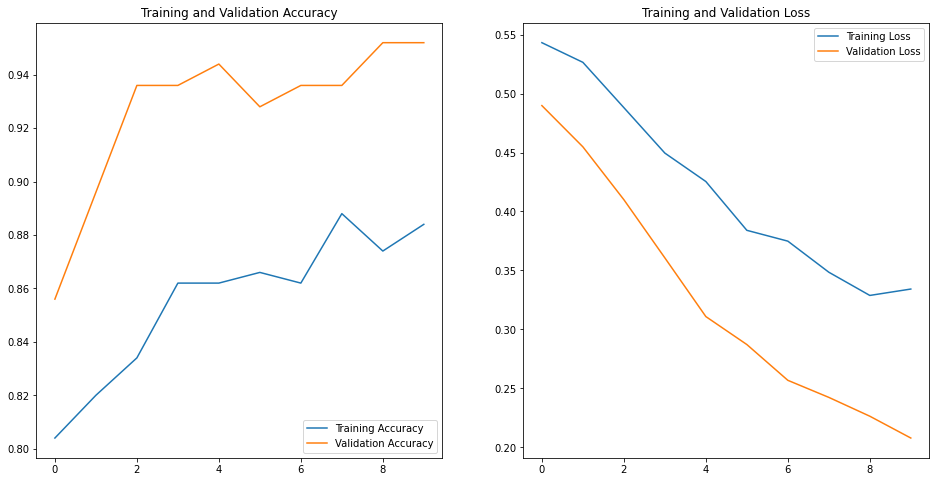

In [28]:
# Plot the training and validation accuracy and loss graphs

acc = model.history['acc']
val_acc = model.history['val_acc']

loss = model.history['loss']
val_loss = model.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Testing the model with a sample image from the test dataset

In [29]:
class_names = list(train_generator.class_indices.items())
print(class_names)

[('fake', 0), ('real', 1)]


In [30]:
test_image_path = "dataset/fake/10 rupees Images_ Stock Photos.jpg"

In [31]:
test_image_read_1 = cv2.imread(test_image_path)
# test_image_read_1 = img.reshape(None, 150, 150, 3)
test_image_1 = process_jpg_image(test_image_read_1)
prediction_1 = vgg.predict(test_image_1)
print(f'dimensions of image used for prediction is: ',test_image_1.shape)
print(prediction_1)

1/1 [==============================] - 0s 190ms/step
dimensions of image used for prediction is:  (1, 224, 224, 3)
[[0.78031695 0.21968302]]


## Predicting all the images in the test dataset and plotting a confusion matrix

In [32]:
# Get the labels of all the images
true_labels = validation_generator.labels
# Making the predictions of all the validation images
all_predictions = vgg.predict(validation_generator)

2/2 [==============================] - 22s 10s/step


In [33]:
preds = []
for items in all_predictions:
    preds.append(np.argmax(items))
    

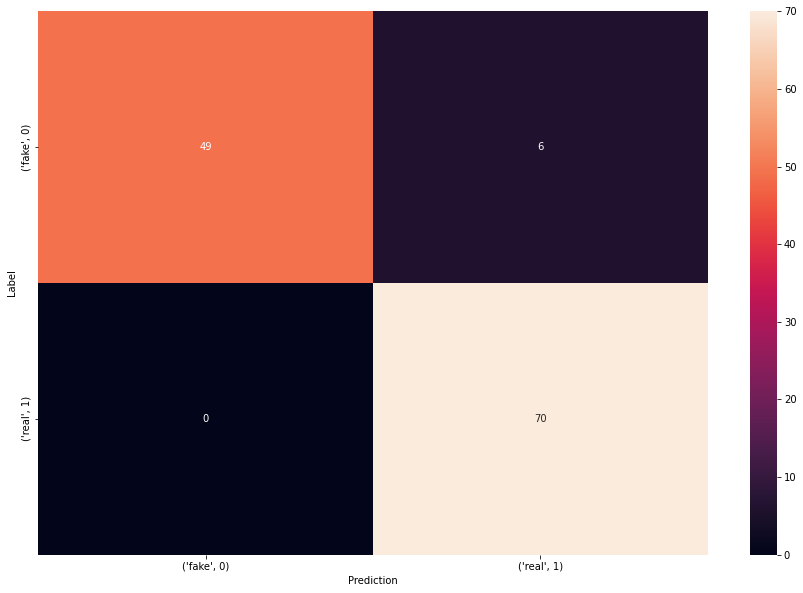

In [34]:
# plot the confusion matrix

confusion_mat = tf.math.confusion_matrix(
    true_labels, preds, dtype=tf.dtypes.int32)

show_confusion_matrix(confusion_mat, class_names)

In [35]:
f1 = f1_score(true_labels, preds, average='weighted')
print(f"F1 score of the model is", f1)

F1 score of the model is 0.9516016859852475


In [36]:
!pip freeze

absl-py==1.0.0
altair==4.2.2
anyio==3.6.2
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arrow==1.2.3
astunparse==1.6.3
attrs==22.2.0
backcall==0.2.0
beautifulsoup4==4.11.2
bleach==6.0.0
blinker==1.5
cachetools==5.0.0
certifi==2021.10.8
cffi==1.15.1
charset-normalizer==2.0.12
click==8.0.4
colorama==0.4.6
comm==0.1.2
contourpy==1.0.7
cycler==0.11.0
debugpy==1.4.1
decorator==5.0.9
defusedxml==0.7.1
distlib==0.3.6
docopt==0.6.2
entrypoints==0.3
fastjsonschema==2.16.2
filelock==3.9.0
Flask==2.1.1
flatbuffers==23.3.3
fonttools==4.30.0
fqdn==1.5.1
gast==0.4.0
gitdb==4.0.10
GitPython==3.1.30
google-auth==2.6.0
google-auth-oauthlib==0.4.6
google-pasta==0.2.0
grpcio==1.44.0
gTTS==2.2.4
gunicorn==20.1.0
h5py==3.8.0
idna==3.3
imbalanced-learn==0.10.1
imblearn==0.0
importlib-metadata==4.11.3
ipykernel==6.20.2
ipython==7.27.0
ipython-genutils==0.2.0
ipywidgets==8.0.2
isoduration==20.11.0
itsdangerous==2.1.1
jedi==0.18.0
Jinja2==3.0.3
joblib==1.2.0
jsonpointer==2.3
jsonschema==4.17.3
jupyter==1.0.

In [37]:
test_image_path = "/dataset/fake/10 rupees Images_ Stock Photos....jpg"

In [38]:
from PIL import Image
img = Image.open("dataset/fake/10 rupees Images_ Stock Photos.jpg")
img.show()

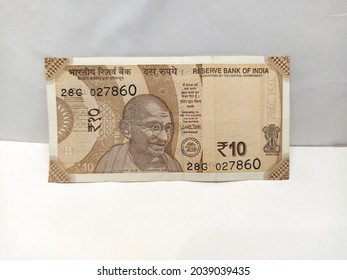

In [39]:
img

In [40]:
prediction_1 = vgg.predict(test_image_1)
prediction_1

1/1 [==============================] - 0s 175ms/step


array([[0.78031695, 0.21968302]], dtype=float32)

In [41]:
test_image_path = "fake_img_2000.jpg"
test_image_read_1 = cv2.imread(test_image_path)
test_image_1 = process_jpg_image(test_image_read_1)
prediction_1 = vgg.predict(test_image_1)
print(f'dimensions of image used for prediction is: ',test_image_1.shape)
print(prediction_1)

1/1 [==============================] - 0s 172ms/step
dimensions of image used for prediction is:  (1, 224, 224, 3)
[[0.94421166 0.05578834]]


In [42]:
import pickle 
with open('fake_currency_detector.pkl', 'wb') as f:
    pickle.dump(get_ipython().getoutput('jupyter nbconvert --to script notebook.ipynb'), f)


In [49]:
test_image_path = "dataset/real/2000_original_IMG_20190421_140542119.jpg_4b42b398-215d-416d-a1ce-9ad9fb75c8d1.jpg"
test_image_read_1 = cv2.imread(test_image_path)
test_image_1 = process_jpg_image(test_image_read_1)
prediction_1 = vgg.predict(test_image_1)
print(f'dimensions of image used for prediction is: ',test_image_1.shape)
print(prediction_1)

1/1 [==============================] - 0s 210ms/step
dimensions of image used for prediction is:  (1, 224, 224, 3)
[[0.26388335 0.7361166 ]]


In [44]:
vgg.save("vgg_model_2.h5")

In [46]:
test_image_path = "dataset/real/2000_original_IMG_20190421_140542119.jpg_4b42b398-215d-416d-a1ce-9ad9fb75c8d1.jpg"
test_image_read_1 = cv2.imread(test_image_path)
test_image_1 = process_jpg_image(test_image_read_1)
prediction_1 = vgg.predict(test_image_1)
print(f'dimensions of image used for prediction is: ',test_image_1.shape)
print(prediction_1)

1/1 [==============================] - 0s 371ms/step
dimensions of image used for prediction is:  (1, 224, 224, 3)
[[0.26388335 0.7361166 ]]


In [52]:
test_image_path = "dataset/real/200_original_IMG_20190422_063730704.jpg_e8b9f697-aba9-45b4-8b88-48f9974661b9.jpg"
test_image_read_1 = cv2.imread(test_image_path)
test_image_1 = process_jpg_image(test_image_read_1)
prediction_1 = vgg.predict(test_image_1)
print(f'dimensions of image used for prediction is: ',test_image_1.shape)
print(prediction_1)

1/1 [==============================] - 0s 147ms/step
dimensions of image used for prediction is:  (1, 224, 224, 3)
[[0.030529   0.96947104]]
